In [564]:
import matplotlib
import numpy as np
from numpy.linalg import norm
from numpy.random import uniform

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

In [565]:
class System2D:
    def __init__(self, x_size: int, y_size: int, N: int, mass: float, periodic_boundary: bool = True):
        self.particle_x_position = uniform(0, x_size, N)
        self.particle_y_position = uniform(0, y_size, N)

        self.particle_x_velocity = np.zeros(N)
        self.particle_y_velocity = np.zeros(N)

        self.particle_x_force = np.zeros(N)
        self.particle_y_force = np.zeros(N)

        self.x_size = x_size
        self.y_size = y_size
        self.N = N
        self.m = mass

        self.periodic_boundary = periodic_boundary
        self.cutoff_radius = np.sqrt(x_size * x_size + y_size * y_size) / 2
        # self.molecular_diameter = 0.3405 * 10 ** (-9) # in nm

        self.dt = 10 ** (-3)
        self.dt_2 = self.dt ** 2
        self.dt_2m = self.dt / (2 * self.m)
        self.dt_2_2m = self.dt_2 / (2 * self.m)
        return
        
    def update(self):
        _updated_x_forces, _updated_y_forces = self._get_updated_forces()
        
        self._update_velocities(_updated_y_forces, _updated_y_forces)
        self._update_forces(_updated_x_forces, _updated_y_forces)
        
        self._update_positions()
        return

    def _update_positions(self):
        self.particle_x_position += self.particle_x_velocity * self.dt + self.dt_2_2m * self.particle_x_force
        self.particle_y_position += self.particle_y_velocity * self.dt + self.dt_2_2m * self.particle_y_force
        return

    def _update_velocities(self, updated_x_forces, updated_y_forces):
        self.particle_x_velocity += (updated_x_forces + self.particle_x_force) * self.dt_2m
        self.particle_y_velocity += (updated_y_forces + self.particle_y_force) * self.dt_2m
        return

    def _update_forces(self, updated_x_forces, updated_y_forces):
        self.particle_x_force = updated_x_forces
        self.particle_y_force = updated_y_forces
        return
        
    def _get_updated_forces(self):
        updated_x_forces = self.particle_x_force
        updated_y_forces = self.particle_y_force
        
        dx = self.particle_x_position[:, np.newaxis] - self.particle_x_position
        dy = self.particle_y_position[:, np.newaxis] - self.particle_y_position

        if self.periodic_boundary:
            dx = dx - self.x_size * np.rint(dx / self.x_size)
            dy = dy - self.y_size * np.rint(dy / self.y_size)
        
        dx_2 = dx * dx
        dy_2 = dy * dy
    
        r_2 = dx_2 + dy_2

        for i in range(len(r_2)):
            idx = np.where((r_2[i] != 0) & (r_2[i] < self.cutoff_radius))[0]
            # print(idx)
            _r_2 = r_2[i][idx]
            _r_2_i = 1 / _r_2
            _r_6_i = np.power(_r_2_i, 3)

            for j in range(len(idx)):
                _f = 48 * _r_2_i[j] * _r_6_i[j] * (_r_6_i[j] - 0.5)
                updated_x_forces[i] += _f * dx[i][idx[j]]
                updated_x_forces[i] += _f * dy[i][idx[j]]    
                
        return updated_x_forces, updated_x_forces

In [566]:
# box size
L: int = 10
# number of particles
N: int = 10
# particle mass
mass: float = 1.0

In [567]:
MD_system2d = System2D(L, L, N, mass)

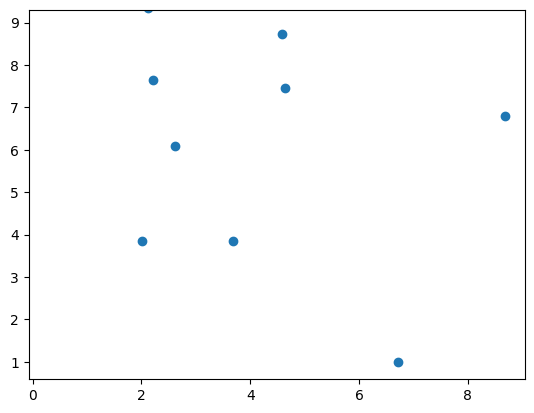

In [568]:
fig, ax = plt.subplots()
scat = ax.scatter(MD_system2d.particle_x_position, MD_system2d.particle_y_position)

# Function to update the plot
def update(frame):
    MD_system2d.update()
    scat.set_offsets(np.c_[MD_system2d.particle_x_position, MD_system2d.particle_y_position])

# Create an animation
ani = animation.FuncAnimation(fig, update, frames=100, interval=200)
ani.save("animation.html", writer='html')